# Statistics, Part II

This week, we are learning basic tools for statistical testing. We've already covered how to create lines of best fit on scatterplots. In today's lecture, we will learn how to measure correlation and test it for statistical significance.

In [36]:
# Run this cell first to import libraries and modules
from datascience import *
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from scipy.stats import ttest_ind, f_oneway
from scipy.stats.stats import pearsonr, spearmanr
import statsmodels.stats.multicomp as mc
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error

Recall from Monday's lecture that in our lexical decision task dataset, word frequency and reaction time had an inverse relationship: the higher the frequency, the lower the reaction time.

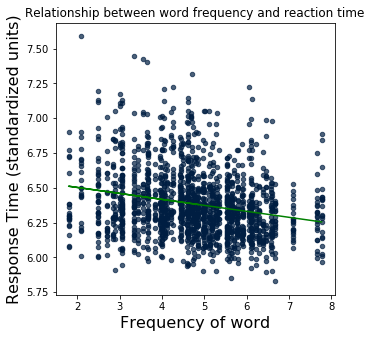

In [2]:
t = Table.read_table('wk4-lexicaldecision.csv')
t.scatter('Frequency','RT')
slope, intercept = np.polyfit(t.column('Frequency'),t.column('RT'),deg=1)
fit = np.multiply(slope,t.column('Frequency')) + intercept
plt.plot(t.column('Frequency'),fit, color='green')
plt.title('Relationship between word frequency and reaction time')
plt.xlabel('Frequency of word')
_ = plt.ylabel('Response Time (standardized units)')

Today, we're going to look at this relationship a little bit more closely, and test for the strength and significance of the correlation.

## Testing correlation
Correlation is a common measure of association. Other measures like this include regression, odds ratio, and chi-square tests.

So, how strong is the linear relationship between word frequency and response time?

Pearson's r is a measure of *linear correlation*. Pearson's r ranges from -1 and 1, where 1 is total positive linear correlation and -1 is total negative linear correlation. Keep in mind that a measure of association is not the same as a measure of statistical significance. A strong correlation can still be statistically insignificant, and a weak correlation can be statistically significant.

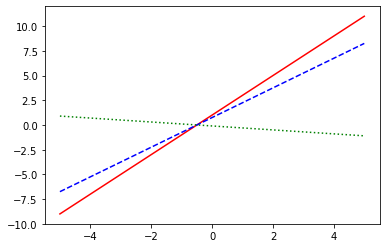

In [3]:
x = np.linspace(-5,5,100)
y = 2*x+1
plt.plot(x, y, '-r')       # linestyle - and color r (red)
plt.plot(x, 0.75*y, '--b') # linestyle -- and color b (blue)
plt.plot(x, -0.1*y, ':g')  # linestyle dots and color g (green)

Pearson's r can be computed using `pearsonr(x,y)` from the module `scipy.stats.stats`. It returns two values: r and the significance value (the p-value):

In [4]:
r, p = pearsonr(t.column('Frequency'), t.column('RT'))
report = "Word frequency and response time have a weak negative correlation, r = {}, p = {}."
report.format(r.round(2),p.round(4))

'Word frequency and response time have a weak negative correlation, r = -0.23, p = 0.0.'

Here, the p-value is very low -- probably not actually zero, but rounds down to it -- and we can thus reject the null hypothesis that the correlation we see might be just due to chance. In our dataset, word frequency and response time have a statistically significant negative correlation!

In the event that your data are not linearly correlated, you may want to use a Spearman's rho measure instead of a Pearson's r. Spearman's rho is a non-linear measure of correlation. It measures how well two variables can be described using a *monotonic function*. Simply put, a monotonic function is one in which wherever x increases (or decreases) y also increases (or decreases). It can be calculated with `spearmanr(x,y)`.

Remember the third degree polynomial we created earlier? Since `x2` and `y2` is monotonically increasing, their Spearman's rho is 1:

In [5]:
x = [-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5]
y = [-125, -64, -10, -5, -1, 0, 3, 6, 17, 64, 126]

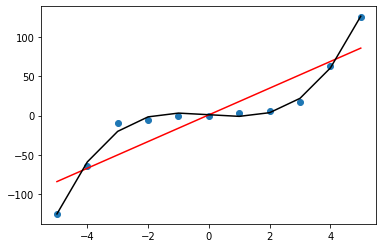

In [6]:
plt.scatter(x,y)
slope,intercept = np.polyfit(x,y,1)
straightline = np.multiply(x,slope) + intercept
z3,z2,z1,z0 = np.polyfit(x,y,3)
curvedline = np.multiply(z3,np.power(x,3)) + np.multiply(z2,np.power(x,2)) + np.multiply(x,z1) + z0
plt.plot(x,straightline, color='red')
plt.plot(x,curvedline, color='black')

In [7]:
rho, p1 = spearmanr(x, y)
r, p2 = pearsonr(x, y)
report = "X and Y have a positive correlation, Spearman's rho = {}, p = {}.\n\
(But when calculating with Pearon's r, r = {}, p = {}.)"
#report.format(rho.round(2), p1.round(2), r.round(2), p2.round(2))
print(report.format(rho.round(2), p1.round(2), r.round(2), p2.round(2)))

X and Y have a positive correlation, Spearman's rho = 1.0, p = 0.0.
(But when calculating with Pearon's r, r = 0.89, p = 0.0.)


## Measuring error of fitted lines

Now that we have our fitted lines and a measure of association, how well does our fitted line actually fit the data? We can find out by calculating *mean squared error*: the goodness of fit between the observed values, $Y$, and the predicted values, $\hat{Y}$.

$$MSE = \frac{1}{n} \sum_{i=1}^{n} (Y_i - \hat{Y_i})^2$$

Unlike correlation, error is unbounded, meaning that it can range from 0 to infinity.

Mean squared error (MSE) can be computed using the `mean_squared_error` function from `sklearn.metrics`. Let's calculate MSE for our first line of best fit, the straight line:

In [8]:
mean_squared_error(y, straightline)

746.8958677685952

Taking the MSE of the curved line (our third-degree polynomial line of best fit) results in a much, much lower value. Less error! We can now quantatively show that the higher-order polynomial was a much better fit to the data than the straight line.

In [9]:
mean_squared_error(y, curvedline)

19.429010383555834

It is also fairly common to see root-mean-square error, also known as root-mean-square deviation, or root-mean-square*d* error (in Data 8 and elsewhere): 

$$RMSE = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (Y_i - \hat{Y_i})^2}$$

The main motivation for using RMSE over MSE is that RMSE has the same units as the predicted variable, so it is easier to interpret. There isn't a built-in RMSE function, but it is easy to use `np.sqrt()` to calculate RMSE.

In [10]:
RMSE = np.sqrt(mean_squared_error(y, curvedline))
RMSE

4.407835113018162

What we call the **regression line** is the straight line that reduces the MSE or RMSE the most, among all possible straight lines.

Suppose we wanted to fit a higher-order polynomial to our lexical decision task scatterplot, just for kicks...

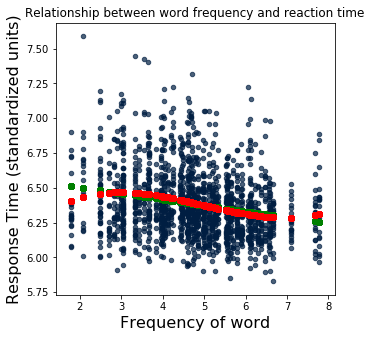

In [11]:
t.scatter('Frequency','RT')
slope, intercept = np.polyfit(t.column('Frequency'),t.column('RT'),deg=1)
fit = np.multiply(slope,t.column('Frequency')) + intercept
p3,p2,p1,p0 = np.polyfit(t.column('Frequency'),t.column('RT'),deg=3)
fit3 = np.multiply(p3,np.power(t.column('Frequency'),3)) +\
       np.multiply(p2,np.power(t.column('Frequency'),2)) +\
       np.multiply(p1,t.column('Frequency')) + p0
plt.scatter(t.column('Frequency'),fit, color='green')
plt.scatter(t.column('Frequency'),fit3, color='red')
plt.title('Relationship between word frequency and reaction time')
plt.xlabel('Frequency of word')
_ = plt.ylabel('Response Time (standardized units)')

In [12]:
MSE1 = mean_squared_error(t.column('RT'), fit)
MSE3 = mean_squared_error(t.column('RT'), fit3)
print(MSE1, MSE3)

0.05530533457643924 0.05483418415225656


In [13]:
RMSE1 = np.sqrt(mean_squared_error(t.column('RT'), fit))
RMSE3 = np.sqrt(mean_squared_error(t.column('RT'), fit3))
print(RMSE1, RMSE3)

0.23517086251582964 0.23416700056211284


In this case, the higher-order polynomial didn't necessarily lower the MSE or RMSE.

# Comparing groups

What if we want to look at the relationship between response time and a discrete (not continuous) variable, such as speaker gender or word class? In that case, we couldn't make a scatterplot or create a regression line. Try it:

In [14]:
# This will throw an error
t.scatter('Frequency','Sex')

ValueError: The column 'Sex' contains non-numerical values. A plot cannot be drawn for this column.

But we have compared groups before using histograms.

In [15]:
t.show(5)

Subject,RT,Trial,Sex,NativeLanguage,Correct,PrevType,PrevCorrect,Word,Frequency,FamilySize,SynsetCount,Length,Class,FreqSingular,FreqPlural,DerivEntropy,Complex,rInfl,meanRT,SubjFreq,meanSize,meanWeight,BNCw,BNCc,BNCd,BNCcRatio,BNCdRatio
A1,6.34036,23,F,English,correct,word,correct,owl,4.85981,1.38629,0.693147,3,animal,54,74,0.7912,simplex,-0.310155,6.3582,3.12,3.4758,3.1806,12.0571,0,6.1756,0,0.512198
A1,6.3081,27,F,English,correct,nonword,correct,mole,4.60517,1.09861,1.94591,4,animal,69,30,0.6968,simplex,0.814508,6.415,2.4,2.9999,2.6112,5.73881,4.06225,2.85028,0.707856,0.496667
A1,6.34914,29,F,English,correct,nonword,correct,cherry,4.99721,0.693147,1.60944,6,plant,83,49,0.4754,simplex,0.518794,6.3426,3.88,1.6278,1.2081,5.71652,3.2498,12.5887,0.568493,2.20217
A1,6.18621,30,F,English,correct,word,correct,pear,4.72739,0,1.09861,4,plant,44,68,0,simplex,-0.427444,6.3353,4.52,1.9908,1.6114,2.05037,1.46241,7.36322,0.713242,3.59117
A1,6.02587,32,F,English,correct,nonword,correct,dog,7.66763,3.13549,2.07944,3,animal,1233,828,1.2129,simplex,0.397796,6.2956,6.04,4.6429,4.5167,74.8385,50.8594,241.561,0.679589,3.22777


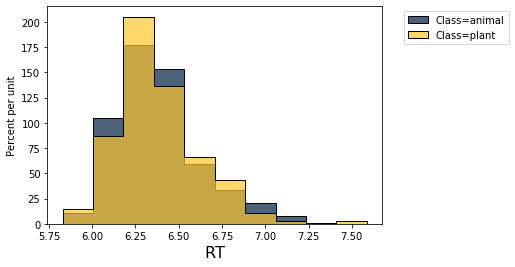

In [114]:
t.hist('RT',group='Class')

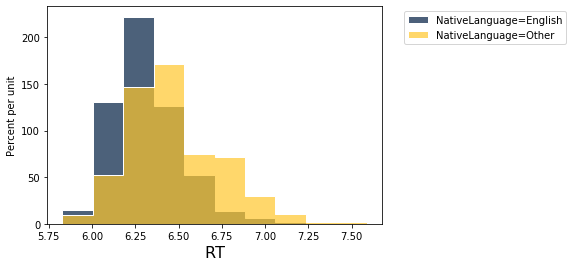

In [16]:
t.hist('RT',group='NativeLanguage',edgecolor='white')

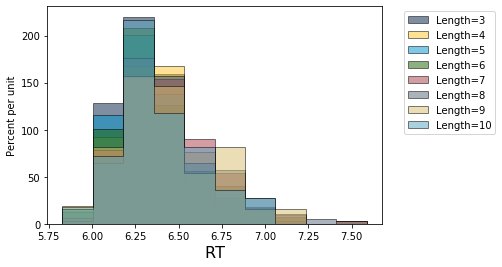

In [17]:
t.hist('RT',group='Length',alpha=0.5)

With two fairly normally-distributed groups that are about equivalent in their distribution, such as the two factors in "NativeLanguage", we can perform a simple two-tailed t-test. In this test, the means of each group are compared to look for a statistically significant difference. The null hypothesis would be that the two means are equal. If the resulting p-value is very small, we could reject this null hypothesis.

`ttest_ind(a, b)` is the function from `scipy.stats` to use.

We will give it two groups to compare, and the output will be a test statistic t-value (where regardless of positive or negative, a relatively higher score indicates  larger difference of means), and a p-value, which we use to determine the significance of the difference.

In [28]:
a = t.where('NativeLanguage','English').column('RT')
b = t.where('NativeLanguage','Other').column('RT')
print(np.mean(a).round(3), np.mean(b).round(3))
ttest_ind(a, b)

6.318 6.474


Ttest_indResult(statistic=-13.719601453299273, pvalue=1.180238649046768e-40)

In [29]:
c = t.where('Class','animal').column('RT')
d = t.where('Class','plant').column('RT')
print(np.mean(c).round(3), np.mean(d).round(3))
ttest_ind(c, d)

6.388 6.382


Ttest_indResult(statistic=0.5020944110881589, pvalue=0.6156678225266126)

What if we have multiple groups? We can use a different kind of statistical test called an Analysis of Variance test, or ANOVA. ANOVA is usually used to compare at least 3 groups, although it can be used for 2 groups. The ANOVA tests for whether one of the groups being tested is different from all the others. (It does not necessarily tell you which one!) Here, the null hypothesis is that there is no difference between the means of any of the groups.

`f_oneway(a, b)` from `scipy.stats` is the function to use for a one-way ANOVA (comparing groups in one category (or column)). Let's try it first on the groups that we already tested using the t-test.

In [1]:
f_oneway(c, d)

NameError: name 'f_oneway' is not defined

The f-statistic returned here is not the same as the t-value, but what it has measured here is a similar comparison of values within one group to values between the groups. The p-value, again, will tell us if it is below a threshold that allows us to reject the null hypothesis of no difference.

How about a comparison of many groups?

In [32]:
for i in np.arange(3,11):
    print("Mean RT for words with length",i,"=",np.mean(t.where('Length',i).column('RT')).round(3))

Mean RT for words with length 3 = 6.305
Mean RT for words with length 4 = 6.38
Mean RT for words with length 5 = 6.354
Mean RT for words with length 6 = 6.37
Mean RT for words with length 7 = 6.436
Mean RT for words with length 8 = 6.461
Mean RT for words with length 9 = 6.435
Mean RT for words with length 10 = 6.401


In [33]:
anova = f_oneway(t.where('Length',3).column('RT'),
                 t.where('Length',4).column('RT'),
                 t.where('Length',5).column('RT'),
                 t.where('Length',6).column('RT'),
                 t.where('Length',7).column('RT'),
                 t.where('Length',8).column('RT'),
                 t.where('Length',9).column('RT'),
                 t.where('Length',10).column('RT'))
anova

F_onewayResult(statistic=8.879483222805142, pvalue=9.070992519187562e-11)

Here is one way to report the results of the ANOVA:

**There is a statistically significant difference between the groups and their response time, F=8.879, p<0.001.**

What we don't know, however, is which group(s) was different from the rest. We can run a post-hoc test to determine this. To compare the means, you'll need to use the function `MultiComparison()` from the library `multicomp`, which we imported as `mc` earlier. Then, you'll use the method `.tukeyhsd()` to conduct the Tukey's "Honestly Significant Difference" (HSD) test. The result of this test is a table that you can scan to see which paired group comparisons have a significant difference between them. (This will save you time from conducting many, many t-tests!)

In [35]:
comp = mc.MultiComparison(t.column('RT'), t.column('Length'))
post_hoc_res = comp.tukeyhsd()
post_hoc_res.summary()

group1,group2,meandiff,lower,upper,reject
3,4,0.0753,0.0006,0.1499,True
3,5,0.0488,-0.0175,0.1151,False
3,6,0.0655,-0.0034,0.1344,False
3,7,0.1313,0.0548,0.2077,True
3,8,0.1557,0.0811,0.2303,True
3,9,0.1297,0.04,0.2194,True
3,10,0.0957,-0.0108,0.2022,False
4,5,-0.0264,-0.0879,0.035,False
4,6,-0.0098,-0.074,0.0545,False
4,7,0.056,-0.0163,0.1283,False


If the value under "reject" is `True`, then we are able to reject the null hypothesis of no significant difference between means. If it is false, then the two groups being compared are not significantly different. In this case, there are several groups that differ significantly, including words of length: 3 vs. 4, 3 vs. 7, 3 vs. 8, 3 vs. 9, 4 vs. 8, 5 vs. 7, 5 vs. 8, 5 vs. 9, and 6 vs. 8. Of course, we should be careful before we make any conclusions about all of these statistical results. There are a lot of assumptions we need to make about our data before we draw conclusions based on statistical tests, assumptions that we have glossed over, because they are not within the scope of this course. Always keep in mind that, just as we know correlation does not always imply causation, finding statistically significant differences between groups does not always imply a meaningful relationship between the grouping and the variable you are studying.

Now that we are able to run statistical tests on our data, a useful next step is to make *predictions* about one variable based on a *model* of the data. In the next lecture, we will learn how to fit linear models to this lexical decision task data.